/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa


=== Results (DL, XGB, PPO Static, PPO Sequential) ===
   Accuracy  Precision    Recall  F1-Score             Model  Time (s)
5  0.993862   0.993854  0.993862  0.993848      PPO (Static)     12.85
6  0.993424   0.993430  0.993424  0.993426  PPO (Sequential)     22.25
4  0.992986   0.992974  0.992986  0.992969           XGBoost      0.00
2  0.984217   0.984164  0.984217  0.984180           Bi-LSTM     22.91
0  0.983779   0.983730  0.983779  0.983747               CNN      1.21
3  0.983341   0.983290  0.983341  0.983221      Stacked LSTM     20.84
1  0.978518   0.978764  0.978518  0.978608              LSTM     11.33


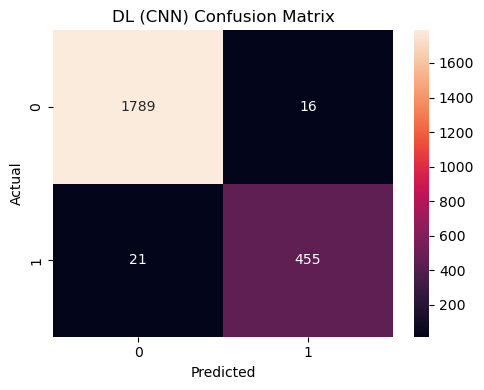

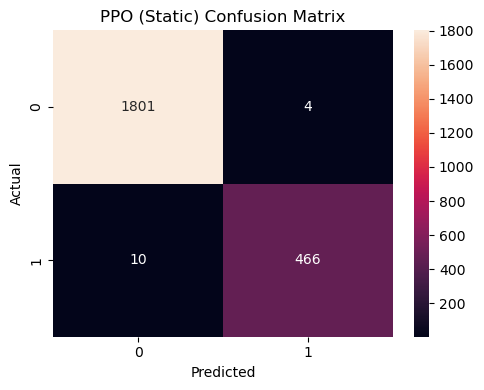

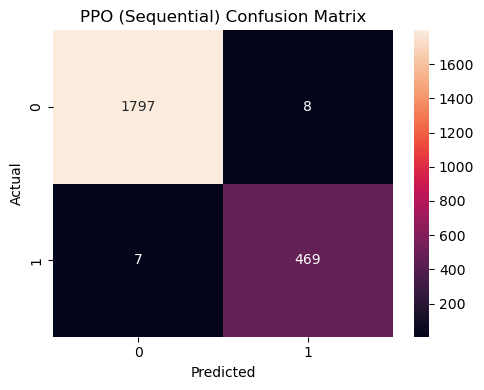

In [ ]:

# BASELINE CODE 

import os
import time
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


import random
random.seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Bidirectional, Flatten, Input
from tensorflow.keras.optimizers import Adam



file_path = os.path.join("Data", "Hybrid_Augmented_TSAFE_Features.xlsx")
df = pd.read_excel(file_path)


if 'Plant_Destination' not in df.columns:
    if {'Plant Code', 'Destination Port'}.issubset(df.columns):
        df['Plant_Destination'] = (
            df['Plant Code'].astype(str) + ' | ' + df['Destination Port'].astype(str)
        )
    else:
        raise ValueError("Cannot create 'Plant_Destination' because 'Plant Code' or 'Destination Port' is missing.")

cat_features = [
    'Origin Port',
    'Carrier',
    'Plant Code',
    'Destination Port',
    'Plant_Destination',       

num_features = [
  
    'Unit quantity',
    'Weight',
    'TPT',

    # Empirically validated augmented features
    'TPT_per_Unit',            # p<0.001, SHAP rank #10
    'LeadTime_Deviation',      # p<0.001, SHAP rank #2
    'Weight_per_Unit',         # SHAP rank #6
    'log_UnitQty',             # SHAP rank #3 (interaction)
    'carrier_origin_risk',     # p<0.001, SHAP rank #1
    'route_cum_late_rate',     # p<0.001, SHAP rank #4
    'route_bb_mean',           # p<0.001, SHAP rank #12
    'carrier_bb_mean',         # p<0.001, SHAP rank #13
    'route_orders_last7d',     # p<0.001, SHAP rank #9
    'route_roll10_Weight_q90', # p=0.0053, SHAP rank #7

    # NEW (from your stats/SHAP list)
    'congestion_trend',
    'Weight_vsCarrierMean',
    'seq_pos_norm',
]


requested_cols = cat_features + num_features
missing = [c for c in requested_cols if c not in df.columns]
if missing:
    print(f"[WARN] These requested columns are missing and will be skipped: {missing}")
   
    cat_features = [c for c in cat_features if c in df.columns]
    num_features = [c for c in num_features if c in df.columns]


X = pd.get_dummies(df[cat_features + num_features], drop_first=False)
y = (df['Ship Late Day count'] > 0).astype(int)  # keep binary target consistent


X = pd.get_dummies(df[cat_features + num_features], drop_first=False)
y = (df['Ship Late Day count'] > 0).astype(int)


X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)


smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled  = scaler.transform(X_test)


def calculate_metrics(y_true, y_score_or_pred):
    """Accepts probabilities or hard labels. If not in {0,1}, threshold @0.5."""
    arr = np.asarray(y_score_or_pred).reshape(-1)
    if set(np.unique(arr)) <= {0,1}:
        y_pred = arr.astype(int)
    else:
        y_pred = (arr >= 0.5).astype(int)
    return {
        'Accuracy':  accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted', zero_division=1),
        'Recall':    recall_score(y_true, y_pred, average='weighted', zero_division=1),
        'F1-Score':  f1_score(y_true, y_pred, average='weighted', zero_division=1)
    }


xgb = GridSearchCV(
    estimator=XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    ),
    param_grid={
        'n_estimators': [100],
        'max_depth': [3, 5],
        'learning_rate': [0.1, 0.05],
        'subsample': [0.8]
    },
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
xgb_proba = xgb.best_estimator_.predict_proba(X_test)[:, 1]
xgb_metrics = calculate_metrics(y_test, xgb_proba)


def create_model(model_type, input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim, 1)))
    if model_type == 'CNN':
        model.add(Conv1D(64, 2, activation='relu'))
        model.add(Flatten())
    elif model_type == 'LSTM':
        model.add(LSTM(64, activation='tanh'))
    elif model_type == 'Bi-LSTM':
        model.add(Bidirectional(LSTM(64, activation='tanh')))
    elif model_type == 'Stacked LSTM':
        model.add(LSTM(64, activation='tanh', return_sequences=True))
        model.add(LSTM(32, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=1e-3, clipnorm=1.0), loss='binary_crossentropy')
    return model


X_train_dl = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1)
X_test_dl  = X_test_scaled.reshape(-1,  X_test_scaled.shape[1],  1)

dl_models = ['CNN', 'LSTM', 'Bi-LSTM', 'Stacked LSTM']
results = []
dl_outputs = {}  

for m in dl_models:
    mdl = create_model(m, X_train_dl.shape[1])
    t0 = time.time()
    mdl.fit(X_train_dl, y_train_res, epochs=10, batch_size=256, verbose=0)
    duration = round(time.time() - t0, 2)
    proba = mdl.predict(X_test_dl, verbose=0).reshape(-1)
    dl_outputs[m] = proba
    met = calculate_metrics(y_test, proba)
    met.update({'Model': m, 'Time (s)': duration})
    results.append(met)


xgb_met = xgb_metrics.copy()
xgb_met.update({'Model': 'XGBoost', 'Time (s)': 0.0})
results.append(xgb_met)


ppo_input_static = np.vstack([
    xgb_proba,
    dl_outputs['CNN'],
    dl_outputs['LSTM'],
    dl_outputs['Bi-LSTM'],
    dl_outputs['Stacked LSTM']
]).T.astype(np.float32)

ppo_input_static = MinMaxScaler().fit_transform(ppo_input_static).astype(np.float32)
ppo_labels_static = y_test.values.astype(int)

class PPOHybridEnv(gym.Env):
    """
    Static classification PPO (independent rows).
    Observation: (5,) stacked model outputs in [0,1].
    Action: {0,1}. Reward: +1 correct, -5 incorrect (cost-sensitive).
    """
    metadata = {"render_modes": []}

    def __init__(self, inputs, labels, pos_reward=1.0, neg_reward=-5.0):
        super().__init__()
        self.inputs = inputs
        self.labels = labels
        self.n = len(labels)
        self.pos_reward = pos_reward
        self.neg_reward = neg_reward
        self.observation_space = spaces.Box(low=0, high=1, shape=(inputs.shape[1],), dtype=np.float32)
        self.action_space = spaces.Discrete(2)
        self.idx = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.idx = 0
        return self.inputs[self.idx], {}

    def step(self, action):
        reward = self.pos_reward if action == self.labels[self.idx] else self.neg_reward
        self.idx += 1
        terminated = self.idx >= self.n
        obs = np.zeros(self.inputs.shape[1], dtype=np.float32) if terminated else self.inputs[self.idx]
        return obs, float(reward), terminated, False, {}


env_static = make_vec_env(lambda: PPOHybridEnv(ppo_input_static, ppo_labels_static), n_envs=1)
ppo_model_static = PPO("MlpPolicy", env_static, verbose=0, seed=42)
t0 = time.time()
ppo_model_static.learn(total_timesteps=50_000)
ppo_static_time = round(time.time() - t0, 2)


env_eval_static = PPOHybridEnv(ppo_input_static, ppo_labels_static)
obs, _ = env_eval_static.reset()
ppo_preds_static = []
done = False
while not done:
    action, _ = ppo_model_static.predict(obs, deterministic=True)
    ppo_preds_static.append(int(action))
    obs, _, done, _, _ = env_eval_static.step(action)

ppo_metrics_static = calculate_metrics(ppo_labels_static, np.array(ppo_preds_static))
ppo_metrics_static.update({'Model': 'PPO (Static)', 'Time (s)': ppo_static_time})
results.append(ppo_metrics_static)


test_idx = X_test.index
test_frame = df.loc[test_idx, ['Order Date', 'Origin Port', 'Destination Port', 'Carrier']].copy()
test_frame['Order Date'] = pd.to_datetime(test_frame['Order Date'])


test_frame['y']       = y_test.values.astype(int)
test_frame['xgb']     = xgb_proba
for m in dl_models:
    test_frame[m] = dl_outputs[m]


test_frame['route_key'] = (
    test_frame['Origin Port'].astype(str) + ' | ' +
    test_frame['Destination Port'].astype(str) + ' | ' +
    test_frame['Carrier'].astype(str)
)


test_frame = test_frame.sort_values('Order Date').reset_index(drop=True)


base_inputs = test_frame[['xgb', 'CNN', 'LSTM', 'Bi-LSTM', 'Stacked LSTM']].values.astype(np.float32)
base_inputs = MinMaxScaler().fit_transform(base_inputs).astype(np.float32)
labels_sorted = test_frame['y'].values.astype(int)
route_sorted  = test_frame['route_key'].values


episodes = []
start = 0
for i in range(1, len(test_frame) + 1):
    if i == len(test_frame) or route_sorted[i] != route_sorted[i-1]:
        episodes.append(slice(start, i))
        start = i

class SequentialPPOEnv(gym.Env):
    """
    Sequential PPO with temporal state and cost-sensitive rewards.

    Observation = [base_inputs(5), time_sin, time_cos, last_K_actions(K), cum_FP, cum_FN]
    Action      = {0,1}
    Reward:
        +2 correct late (TP), +1 correct on-time (TN)
        -5 false negative (missed late), -2 false positive
        -0.01 step penalty; +0.2 bonus if FN-rate improves vs. previous step
    Episodes follow route continuity in time.
    """
    metadata = {"render_modes": []}

    def __init__(self, base_inputs, labels, episodes, K=5):
        super().__init__()
        self.base_inputs = base_inputs
        self.labels = labels.astype(int)
        self.episodes = episodes
        self.K = K

        self.obs_dim = 5 + 2 + K + 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)

        self._ep_idx = -1
        self._indices = None
        self._t = None
        self._last_actions = None
        self._cum_fp = None
        self._cum_fn = None
        self._prev_fn_rate = 0.0

    def _time_features(self, t, T):
        pos = (t / max(T - 1, 1))
        return np.array([np.sin(2*np.pi*pos), np.cos(2*np.pi*pos)], dtype=np.float32)

    def _obs(self):
        T = len(self._indices)
        cur_idx = self._indices[self._t]
        x = self.base_inputs[cur_idx]  # (5,)
        time_feat = self._time_features(self._t, T)  # (2,)
        lastK = self._last_actions.copy()  # (K,)
        obs = np.concatenate([x, time_feat, lastK, np.array([self._cum_fp, self._cum_fn], dtype=np.float32)], axis=0)
        return obs.astype(np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._ep_idx = (self._ep_idx + 1) % len(self.episodes)
        sl = self.episodes[self._ep_idx]
        self._indices = np.arange(sl.start, sl.stop, dtype=int)
        self._t = 0
        self._last_actions = np.zeros(self.K, dtype=np.float32)
        self._cum_fp = 0.0
        self._cum_fn = 0.0
        self._prev_fn_rate = 0.0
        return self._obs(), {}

    def step(self, action):
        cur_i = self._indices[self._t]
        y = self.labels[cur_i]

      
        if action == y:
            reward = 2.0 if y == 1 else 1.0
        else:
            if y == 1 and action == 0:
                reward = -5.0 
                self._cum_fn += 1.0
            else:
                reward = -2.0  
                self._cum_fp += 1.0

        reward -= 0.01  

    
        steps_so_far = float(self._t + 1)
        fn_rate = self._cum_fn / steps_so_far
        if fn_rate < self._prev_fn_rate:
            reward += 0.2
        self._prev_fn_rate = fn_rate

     
        self._last_actions = np.roll(self._last_actions, -1)
        self._last_actions[-1] = float(action)

   
        self._t += 1
        terminated = self._t >= len(self._indices)
        truncated = False

        obs = np.zeros(self.obs_dim, dtype=np.float32) if terminated else self._obs()
        return obs, float(reward), terminated, truncated, {}


env_seq = make_vec_env(lambda: SequentialPPOEnv(base_inputs, labels_sorted, episodes, K=5), n_envs=1)
ppo_model_seq = PPO("MlpPolicy", env_seq, verbose=0, seed=42)
t0 = time.time()
ppo_model_seq.learn(total_timesteps=80_000)
ppo_seq_time = round(time.time() - t0, 2)
eval_env = SequentialPPOEnv(base_inputs, labels_sorted, episodes, K=5)
obs, _ = eval_env.reset()
seq_preds = []
visited_episodes = 0
while True:
    action, _ = ppo_model_seq.predict(obs, deterministic=True)
    seq_preds.append(int(action))
    obs, _, terminated, truncated, _ = eval_env.step(action)
    if terminated:
        visited_episodes += 1
        if visited_episodes >= len(episodes):
            break
        obs, _ = eval_env.reset()

seq_preds = np.array(seq_preds[:len(labels_sorted)])
seq_metrics = calculate_metrics(labels_sorted, seq_preds)
seq_metrics.update({'Model': 'PPO (Sequential)', 'Time (s)': ppo_seq_time})
results.append(seq_metrics)

results_df = pd.DataFrame(results)
print("\n=== Results (DL, XGB, PPO Static, PPO Sequential) ===")
print(results_df.sort_values('F1-Score', ascending=False))

results_df.to_csv('model_comparison_static_vs_sequential_PPO.csv', index=False)

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, (dl_outputs['CNN'] >= 0.5).astype(int)), annot=True, fmt='d')
plt.title("DL (CNN) Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(ppo_labels_static, np.array(ppo_preds_static)), annot=True, fmt='d')
plt.title("PPO (Static) Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(labels_sorted, seq_preds), annot=True, fmt='d')
plt.title("PPO (Sequential) Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()
